In [140]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.random_projection import GaussianRandomProjection
from sklearn.mixture import GaussianMixture

from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds

from rsq import SVCEnsemble

from joblib import Parallel, delayed

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

In [141]:
# --
# Helpers

def subset(X, y, n):
    if isinstance(X, list):
        sel = np.random.choice(X[0].shape[0], n, replace=False)
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.choice(X.shape[0], n, replace=False)
    
    return X[sel], y[sel]

def shuffle(X, y):
    """ shuffle X and y """
    
    if isinstance(X, list):
        sel = np.random.permutation(X[0].shape[0])
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(X.shape[0])
    return X[sel], y[sel]

def adjust_prevalance(X, y, n_pos):
    """ adjust the prevalance of the positive class """
    
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    sel = np.hstack([
        np.random.choice(pos_idx, n_pos, replace=False),
        neg_idx,
    ])
    
    if isinstance(X, list):
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(sel)
    return X[sel], y[sel]


def process_data(X, y, n_pos_labels, n_all):
    X, y  = shuffle(X, y)

    X = [normalize(x, axis=1, norm='l2') for x in X]

    X, y = subset(X, y, n=n_all)

    target = np.random.choice(np.unique(y)) # !! Uniform sample class, not according to prevalance
    y      = (y == target).astype(np.int)

    X, y = adjust_prevalance(X, y, n_pos_labels)
    
    return X, y
        
def experiment(process_args, experiment_args):
    X, y = process_data(*process_args)
        
    return run_exp(X, y, *experiment_args)

In [142]:
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.random_projection import GaussianRandomProjection
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier

try:
    from thundersvm import SVC as tSVC
except:
    pass

from joblib import Parallel, delayed

    
class ProjectionSVC:
    def __init__(self, projector='gaussian', projection_kwargs={},
                 classes=None,
                 thunder=True,
                 C=1.0, kernel='rbf', degree=3, gamma='scale', 
                 coef0=0.0, shrinking=True, probability=False,
                 tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                 max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None):
        
        if projector == 'gaussian':
            self.projector = GaussianRandomProjection
        else:
            self.projector=projector

        self.projection_kwargs=projection_kwargs
        self.classes_=classes
        
        self.kernel=kernel
        self.C=C
        
        self.thunder=thunder
        
        
    def fit(self, X, y):
        if self.classes_ is None:
            self.classes_ = np.unique(y)

        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]

        self.classes_ = np.unique(y)
        
        if self.thunder:
            self.svc = OneVsRestClassifier(tSVC(kernel=self.kernel, C=self.C))
        else:
            if self.kernel == 'linear':
                self.svc = LinearSVC(C=self.C)
            else:
                self.svc = SVC(kernel=self.kernel, C=self.C)
        
        if self.projector is None:
            self.svc.fit(X, y)
        else:
            self.projector = self.projector(**self.projection_kwargs)
            self.projector.fit(X)
            self.svc.fit(self.projector.transform(X), y)
        
        
        
    def decision_function(self, X):
        if self.projector is not None:
            dfs = self.svc.decision_function(self.projector.transform(X))
        else:
            dfs = self.svc.decision_function(X)
            
        return dfs
        
    
    def predict(self, X):
        if self.projector is None:
            return self.classes_[np.argmax(self.decision_function(X), axis=-1)]
        else:
            return self.classes_[np.argmax(self.decision_function(self.projector.transform(X)), axis=-1)]
        
        
class SemiSupervisedSVC(ProjectionSVC):
    def __init__(self, projector=None, projection_kwargs={}, 
                 classes=None, 
                 thunder=True,
                 cluster_class='gmm', cluster_kwargs={'n_components':-2, 'covariance_type':'spherical'},
                 C=1.0, kernel='rbf', degree=3, gamma='scale', 
                 coef0=0.0, shrinking=True, probability=False,
                 tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                 max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None):
        
        if cluster_class == 'gmm':
            self.cluster_class = GaussianMixture
        elif cluster_class == 'kmeans':
            self.cluster_class = KMeans
        else:
            self.cluster_class=cluster_class
            
        self.cluster_kwargs=cluster_kwargs
        
        super().__init__(projector, projection_kwargs, classes, thunder, C, kernel, degree, gamma, 
                 coef0, shrinking, probability,
                 tol, cache_size, class_weight, verbose, 
                 max_iter, decision_function_shape, break_ties, random_state)
        
        
    def fit(self, X, y, y_induced=None):
        self.unlabeled_inds = np.where(y == -1)[0].astype(int)
        self.labeled_inds = np.where(y != -1)[0].astype(int)
        
        if self.classes_ is None:
            self.classes_ = np.unique(y)

            if -1 in self.classes_:
                self.classes_ = self.classes_[1:]

        
        n_classes = len(self.classes_)        
        if y_induced is None:
            if 'n_components' in list(self.cluster_kwargs.keys()):
                if self.cluster_kwargs['n_components'] < 0:
                    self.cluster_kwargs['n_components'] *= -1
                    self.cluster_kwargs['n_components'] *= len(self.classes_)
                    self.cluster_kwargs['n_components'] = int(self.cluster_kwargs['n_components'])
                self.n_components=self.cluster_kwargs['n_components']
            elif 'n_clusters' in list(self.cluster_kwargs.keys()):
                if self.cluster_kwargs['n_clusters'] < 0:
                    self.cluster_kwargs['n_clusters'] *= -1
                    self.cluster_kwargs['n_clusters'] *= len(self.classes_)
                    self.cluster_kwargs['n_clusters'] = int(self.cluster_kwargs['n_clusters'])
                self.n_components=self.cluster_kwargs['n_clusters']
            else:
                raise ValueError('keyword n_components or n_clusters must be present in cluster_kwargs')
        else:
            self.n_components = len(np.unique(y_induced))
            
                
        if y_induced is None:
            cluster_instance = self.cluster_class(**self.cluster_kwargs)
        
        if self.projector is None:
            if y_induced is None:
                y_induced = cluster_instance.fit_predict(X)
        else:
            self.projector = self.projector(**self.projection_kwargs) 
            self.projector.fit(X)
            if y_induced is None:
                y_induced = cluster_instance.fit_predict(self.projector.transform(X))
         
        self.labels_per_cluster = np.zeros((self.n_components, n_classes))
        
        for i in range(n_classes):
            inds = np.where(y == self.classes_[i])
            temp_y_induced = y_induced[inds]
            temp_counts = np.array([len(np.where(temp_y_induced == c)[0]) for c in range(self.n_components)])
            
            self.labels_per_cluster[:, i] = temp_counts
 
        
        if self.thunder:
            self.svc = OneVsRestClassifier(tSVC(kernel=self.kernel, C=self.C))
        else:
            if self.kernel == 'linear':
                self.svc = LinearSVC(C=self.C)
            else:
                self.svc = SVC(kernel=self.kernel, C=self.C)
        
        if self.projector is None:
            self.svc.fit(X, y_induced)
        else:
            self.svc.fit(self.projector.transform(X), y_induced)
    

    def decision_function(self, X):
        n_labeled = np.sum(self.labels_per_cluster)
        
        if self.projector is None:
            dfs = self.svc.decision_function(X)
        else:
            dfs = self.svc.decision_function(self.projector.transform(X))
            
        return dfs @ self.labels_per_cluster
            

class SVCEnsemble:
    def __init__(self, n_sup=1, n_semisup=1, sup_weight=None, 
                 p_inbag=1, 
                 projector=None, projection_kwargs={},
                 classes=None, n_jobs=1,
                 thunder=False, 
                 induce=0, cluster_class='gmm', cluster_kwargs={'n_components':-2, 'covariance_type':'spherical'},
                 C=1.0, kernel='rbf', degree=3, gamma='scale', 
                 coef0=0.0, shrinking=True, probability=False,
                 tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                 max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None):
        
        self.induce=induce
        self.n_sup=n_sup
        self.n_semisup = n_semisup
        self.sup_weight=sup_weight

        self.p_inbag=p_inbag
        
        self.classes_ = classes
        self.n_jobs=n_jobs
        
        if projector is "gaussian":
            self.projector=GaussianRandomProjection
        else:
            self.projector=projector

        self.projection_kwargs=projection_kwargs
        
        if cluster_class == 'gmm':
            self.cluster_class = GaussianMixture
        elif cluster_class == 'kmeans':
            self.cluster_class = KMeans
            
        self.cluster_kwargs=cluster_kwargs
        
        self.kernel=kernel
        self.C=C
        
        self.thunder=thunder
            
        self.ensemble = []
                
        
    def fit(self, X, y):
        self.unlabeled_inds = np.where(y == -1)[0].astype(int)
        self.labeled_inds = np.where(y != -1)[0].astype(int)
        
        if self.sup_weight is None:
            self.sup_weight = len(self.labeled_inds) / (len(self.labeled_inds) + len(self.unlabeled_inds))
        
        if self.classes_ is None:
            self.classes_ = np.unique(y)

            if -1 in self.classes_:
                self.classes_ = self.classes_[1:]
                
        if self.induce > 0 and self.n_semisup > 0:
            if 'n_components' in list(self.cluster_kwargs.keys()):
                if self.cluster_kwargs['n_components'] < 0:
                    self.cluster_kwargs['n_components'] *= -1
                    self.cluster_kwargs['n_components'] *= len(self.classes_)
                    self.cluster_kwargs['n_components'] = int(self.cluster_kwargs['n_components'])
                self.n_components=self.cluster_kwargs['n_components']
            elif 'n_clusters' in list(self.cluster_kwargs.keys()):
                if self.cluster_kwargs['n_clusters'] < 0:
                    self.cluster_kwargs['n_clusters'] *= -1
                    self.cluster_kwargs['n_clusters'] *= len(self.classes_)
                    self.cluster_kwargs['n_clusters'] = int(self.cluster_kwargs['n_clusters'])
                self.n_components=self.cluster_kwargs['n_clusters']
            else:
                raise ValueError('keyword n_components must be present in cluster_kwargs')
            
            cluster_instance = self.cluster_class(**self.cluster_kwargs)
            self.y_induced=cluster_instance.fit_predict(X)
        else:
            self.y_induced=None
                                
        condensed_func = lambda x: self._train_svc(X, y, x, stratified=True)
        func_tuples = np.concatenate((np.ones(self.n_sup), np.zeros(self.n_semisup))).astype(int)
                
        self.ensemble = Parallel(n_jobs=self.n_jobs)(delayed(condensed_func)(tuple_) for tuple_ in func_tuples)
            
    def _train_svc(self, X, y, supervised=True, stratified=True):                
        if len(self.labeled_inds) == len(y):
            all_supervised=True
        else:
            all_supervised=False

        if self.p_inbag >= 1:
            self.p_inbag=1
            replace=False
        else:
            replace=True
                        
        if supervised:
            bag_inds = stratified_sample(y[self.labeled_inds], p=self.p_inbag, replace=False)
            svc = ProjectionSVC(projector=self.projector, projection_kwargs=self.projection_kwargs, 
                                thunder=self.thunder, classes=self.classes_, kernel=self.kernel, C=self.C)
            svc.fit(X[self.labeled_inds[bag_inds]], y[self.labeled_inds[bag_inds]])
            
        else:
            sbag_inds = stratified_sample(y[self.labeled_inds], p=self.p_inbag, replace=False)
            if all_supervised:
                bag_inds = sbag_inds
            else:
                ssbag_inds = np.random.choice(len(self.unlabeled_inds), size=int(X.shape[0]*0.67), replace=True)
                bag_inds = np.concatenate((self.labeled_inds[sbag_inds], ssbag_inds))
            
            svc = SemiSupervisedSVC(projector=self.projector, projection_kwargs=self.projection_kwargs, 
                                    classes=self.classes_,
                                    thunder=self.thunder,
                                   cluster_class=self.cluster_class, cluster_kwargs=self.cluster_kwargs,
                                    kernel=self.kernel, C=self.C)

            use_pre_induced=np.random.binomial(1, self.induce)
            if use_pre_induced:
                svc.fit(X[bag_inds], y[bag_inds], self.y_induced[bag_inds])
            else:
                svc.fit(X[bag_inds], y[bag_inds])
                    
                
        return svc
    
    def decision_function(self, X):
        if self.n_sup > 0:
            # Play around with different normalization 
            sup_dfs = np.sum([svc.decision_function(X) for svc in self.ensemble[:self.n_sup]], axis=0)
            sup_dfs /= np.sqrt((sup_dfs ** 2).sum(axis=-1, keepdims=True))
        else:
            sup_dfs = 0
        

        if self.n_semisup > 0:    
            semisup_dfs = np.sum([svc.decision_function(X) for svc in self.ensemble[self.n_sup:]], axis=0)
            semisup_dfs /= np.sqrt((semisup_dfs ** 2).sum(axis=-1, keepdims=True))
        else:
            semisup_dfs = 0

        # Play around w voting instead of averaging scores
        return (self.sup_weight * sup_dfs) + ((1 - self.sup_weight) * semisup_dfs)
    
    def predict_proba(self, X):
        return self.decision_function(X)
    
    
    def predict(self, X):
        return np.argmax(self.decision_function(X), axis=1)

In [143]:
# --
# Experiment parameters & initial data loading

np.random.seed(1)


data_files = ['../output/feats/crow_resnet50/birdsnap/'
             ]
models = [s.split('/')[-3] for s in data_files]


X = [np.load(os.path.join(f, 'X.npy')).astype(np.float64) for f in data_files][0]
y_str = np.load(os.path.join(data_files[0], 'y.npy'))
classes_str, class_counts= np.unique(y_str, return_counts=True)
y=np.zeros(len(y_str))
for i, str_ in enumerate(classes_str):
    y[np.where(y_str == str_)[0]] = i

y = y.astype(int)
classes=np.unique(y)

print(X.shape, len(y), len(classes), np.min(class_counts), np.median(class_counts), np.max(class_counts))

(32682, 2048) 32682 500 29 68.0 83


In [144]:
def svc_exp(X, y, p=0.1, acorn=None):
    X = X.copy() / np.sqrt((X.copy() ** 2).sum(axis=-1, keepdims=True))
    
    inds_sup = stratified_sample(y, p, replace=False)
    inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup]).astype(int)

    y_ = -1 * np.ones(n)
    y_[inds_sup] = y[inds_sup]
    
    #- 2 = Supervised, Semisupervised
    accs = np.zeros(2)
    times = np.zeros(2)
        
    print("begin fit1")
    time_ = time()
    
    #- Supervised
    svc_sup = LinearSVC(C=1)
    svc_sup.fit(X[inds_sup], y[inds_sup])
    accs[0] = (svc_sup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[0] = time() - time_
    
    print("begin fit2")
    #- Semi-Supervised
    svc_semisup = SVCEnsemble(n_sup=500, n_semisup=0, p_inbag=1, sup_weight=0.5,
                              thunder=False,
                              cluster_class='kmeans', cluster_kwargs={'n_clusters': -3, 'n_jobs': 3},
                              n_jobs=9,
                              projector='gaussian', projection_kwargs={'n_components': 64},
                              induce=1, classes=classes, kernel='linear')
#     svc_semisup = ProjectionSVC(projector=None, classes=classes, kernel='linear', thunder=False)
    svc_semisup.fit(X[inds_sup], y[inds_sup])
    accs[1] = (svc_semisup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[1] = time() - time_
    time_ = time()
    
    return accs, times

In [145]:
np.random.seed(1)

prop_labeled=[0.2, 0.3, 0.5, 0.8]
n_cores=10
# n_mc=int(n_cores / len(prop_labeled))
n_mc=10

experiment_tuples = []

for i, p in enumerate(prop_labeled):
    for _ in range(n_mc):
        all_inds = stratified_sample(y, p=0.5, replace=False)
        n=len(all_inds)
        
        experiment_tuples.append((X[all_inds], y[all_inds], p))
    

condensed_func = lambda x: svc_exp(*x)
start_time = time()
print(len(experiment_tuples))
try:
    accuracies_and_times = Parallel(n_jobs=n_cores)(delayed(condensed_func)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

40
finished in 7540.4


In [146]:
accuracies = np.zeros((len(prop_labeled), 2, n_mc))
times = np.zeros((len(prop_labeled), 2, n_mc))

for i in range(len(prop_labeled)):
    for j in range(n_mc):
        temp = accuracies_and_times[i*len(prop_labeled) + j]
        accuracies[i,:, j] = temp[0]
        times[i,:, j] = temp[1]

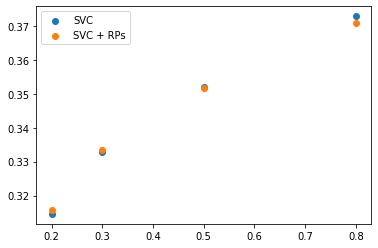

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

algos = ['SVC', 'SVC + RPs']

for i, algo in enumerate(algos):
    ax.scatter(prop_labeled, np.mean(accuracies, axis=-1)[:, i], label=algo)

ax.legend()

In [107]:
X_, y_ = experiment_tuples[0][:-1]
inds = stratified_sample(y_, p=0.1)
y__ = -1 * np.ones(len(y_))
y__[inds] = y_[inds]
print(len(inds))

500


In [108]:
linear_svc = LinearSVC(C=1)
time_ = time()
linear_svc.fit(X_[inds], y__[inds])

print("time to train linear SVC:", time() - time_, (linear_svc.predict(X_) == y_).mean())

time to train linear SVC: 11.246625185012817 0.2704837117472853


In [109]:
# linear_svc_ensemble = ProjectionSVC(projector=None, kernel='linear', thunder=False)
linear_svc_ensemble = SVCEnsemble(n_sup=200, n_semisup=0, sup_weight=0.5, p_inbag=1, 
                         thunder=False, projector='gaussian', projection_kwargs={'n_components': 64},
                                  n_jobs=20,
                        kernel='linear', C=1, cluster_kwargs={'n_components':-2})
time_ = time()
linear_svc_ensemble.fit(X_, y__)
print("time to train linear SVC:", time() - time_,  (linear_svc_ensemble.predict(X_) == y_).mean())

time to train linear SVC: 5.599503040313721 0.28298782494241526


In [110]:
# linear_svc_ensemble = ProjectionSVC(projector=None, kernel='linear', thunder=False)
linear_svc_ensemble = SVCEnsemble(n_sup=100, n_semisup=100, sup_weight=0.5, p_inbag=1,
                                  induce=0,
                         thunder=False, projector='gaussian', projection_kwargs={'n_components': 64},
                                  n_jobs=20,
                        kernel='linear', C=1, cluster_kwargs={'n_components':-3})
time_ = time()
linear_svc_ensemble.fit(X_, y__)
print("time to train linear SVC:", time() - time_,  (linear_svc_ensemble.predict(X_) == y_).mean())

time to train linear SVC: 136.1855399608612 0.2681803224744982


In [111]:
for i in np.arange(11):
    linear_svc_ensemble.sup_weight=i/10
    print(i/10, (linear_svc_ensemble.predict(X_) == y_).mean())

0.0 0.22244159262915433
0.1 0.23132609410990457
0.2 0.2418558736426456
0.3 0.25074037512339586
0.4 0.2592958209937479
0.5 0.2681803224744982
0.6 0.2754195459032576
0.7 0.2783810463968411
0.8 0.28068443566962814
0.9 0.28298782494241526
1.0 0.2836459361632116


In [104]:
# linear_svc_ensemble = ProjectionSVC(projector=None, kernel='linear', thunder=False)
linear_svc_ensemble = SVCEnsemble(n_sup=200, n_semisup=200, sup_weight=0.5, p_inbag=1,
                                  induce=0,
                         thunder=False, projector='gaussian', projection_kwargs={'n_components': 64},
                                  n_jobs=20,
                        kernel='linear', C=1, cluster_kwargs={'n_components':-2})
time_ = time()
linear_svc_ensemble.fit(X_, y__)
print("time to train linear SVC:", time() - time_,  (linear_svc_ensemble.predict(X_) == y_).mean())

time to train linear SVC: 215.69433736801147 0.4257979598552155


In [105]:
for i in np.arange(11):
    linear_svc_ensemble.sup_weight=i/10
    print((linear_svc_ensemble.predict(X_) == y_).mean())

0.24086870681145114
0.3142481079302402
0.35867061533399147
0.38631128660743663
0.40638367884172427
0.4257979598552155
0.4442250740375123
0.45475485357025336
0.462323132609411
0.466600855544587
0.4662717999341889


In [106]:
# linear_svc_ensemble = ProjectionSVC(projector=None, kernel='linear', thunder=False)
linear_svc_ensemble2 = SVCEnsemble(n_sup=400, n_semisup=0, sup_weight=0.5, p_inbag=1,
                                  induce=0,
                         thunder=False, projector='gaussian', projection_kwargs={'n_components': 64},
                                  n_jobs=20,
                        kernel='linear', C=1, cluster_kwargs={'n_components':-2})
time_ = time()
linear_svc_ensemble2.fit(X_, y__)
print("time to train linear SVC:", time() - time_,  (linear_svc_ensemble2.predict(X_) == y_).mean())

time to train linear SVC: 26.94737458229065 0.4652846331029944
